## **Código do melhoramento de imagem**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from scipy import ndimage
from scipy.ndimage import gaussian_filter

from PIL import Image, ImageOps

from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from skimage import io, color, filters, measure

import math
import numpy as np

import os
import sys
from glob import glob
from os.path import join
from ntpath import basename

def colorCorrection(imagem, intensidade):
  resultados = [] #vetor para receber os resultados das trasnformações
  rgb = cv2.split(imagem) #acesso a cada canal de cor
  saturacao = rgb[0].shape[0] * rgb[0].shape[1] * intensidade / 500.0 #200
  for canal in rgb:
      histograma = cv2.calcHist([canal], [0], None, [256], (0,256), accumulate=False)
      #low value
      lowvalue = np.searchsorted(np.cumsum(histograma), saturacao) #soma acumulada dos elementos valor inferior do histograma e encontra índices onde os elementos devem ser inseridos p/ ordenar
      #high value
      highvalue = 255-np.searchsorted(np.cumsum(histograma[::-1]), saturacao)#soma acumulada e sort valores superiores
      #tomar toda a informação (min/max) da curva linear para aplicar e gerar uma LUT de 256 valores a aplicar nos canais stretching
      lut = np.array([0 if i < lowvalue else (255 if i > highvalue else round(float(i-lowvalue)/float(highvalue-lowvalue)*255)) for i in np.arange(0, 256)], dtype="uint8")
      #mescla os canais de volta
      resultados.append(cv2.LUT(canal, lut))
  return cv2.merge(resultados)


def gammaCorrection(image, gamma):  #0.7
#construir uma tabela de novos valores mapeados de pixel [0, 255] para seus valores gama ajustados
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255
  for i in np.arange(0, 256)]).astype("uint8")
  #aplicar a correção
  return cv2.LUT(image, table)


def mascaraNitidez(imagem, sigma, intensidade, kernel=(5, 5), threshold=0): #sigma 1.0/ 0.5, intensidade 2.0/ 1.0
  suavizacao = cv2.GaussianBlur(imagem, kernel, sigma)
  nitidez = float(intensidade + 1) * imagem - float(intensidade) * suavizacao
  nitidez = np.maximum(nitidez, np.zeros(nitidez.shape))
  nitidez = np.minimum(nitidez, 255 * np.ones(nitidez.shape))
  nitidez = nitidez.round().astype(np.uint8)
  if threshold > 0:
      contraste_baixo = np.absolute(imagem - suavizacao) < threshold
      np.copyto(nitidez, imagem, where=contraste_baixo)
  return nitidez


def CLAHE(imagem):
  clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(4, 4))
  for i in range(3):
    imagem[:, :, i] = clahe.apply((imagem[:, :, i]))
  return imagem


def add(a ,b, alfa, beta):
  fusao = cv2.addWeighted(a, alfa, b, beta, 0) #combina duas imagens
  #0.5/0.5 valores alfa e beta
  return fusao

def enhacement(imagem, brightness, contrast): #b=5 c=10
  img = np.int16(imagem)
  img = img * (contrast/127+1) - contrast + brightness
  img = np.clip(img, 0, 255)
  final = np.uint8(img)
  return final


def UWE(image, cci, gamma, alfa, beta, sigma=0.5, intensidade=1.0, brightness=5, contrast=10):

  colorCorrected = colorCorrection(image, cci)
  gammaCorrected = gammaCorrection(colorCorrected, gamma)
  edgeEnhacement = mascaraNitidez(gammaCorrected, sigma, intensidade)
  clahe = CLAHE(colorCorrected)
  gammaCorrected2 = gammaCorrection(colorCorrected, gamma)
  edgeEnhacement2 = mascaraNitidez(gammaCorrected2, sigma, intensidade)
  fusao = add(edgeEnhacement, edgeEnhacement2, alfa, beta)

  output = enhacement(fusao, brightness, contrast)

  return output

### **Métricas de qualidade**

In [ ]:
def getUCIQE(img):
    img_BGR = img
    img_LAB = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2LAB)
    img_LAB = np.array(img_LAB,dtype=np.float64)
    # Trained coefficients are c1=0.4680, c2=0.2745, c3=0.2576 according to paper.
    coe_Metric = [0.4680, 0.2745, 0.2576]

    img_lum = img_LAB[:,:,0]/255.0
    img_a = img_LAB[:,:,1]/255.0
    img_b = img_LAB[:,:,2]/255.0

    # item-1
    chroma = np.sqrt(np.square(img_a)+np.square(img_b))
    sigma_c = np.std(chroma)

    # item-2
    img_lum = img_lum.flatten()
    sorted_index = np.argsort(img_lum)
    top_index = sorted_index[int(len(img_lum)*0.99)]
    bottom_index = sorted_index[int(len(img_lum)*0.01)]
    con_lum = img_lum[top_index] - img_lum[bottom_index]

    # item-3
    chroma = chroma.flatten()
    sat = np.divide(chroma, img_lum, out=np.zeros_like(chroma, dtype=np.float64), where=img_lum!=0)
    avg_sat = np.mean(sat)

    uciqe = sigma_c*coe_Metric[0] + con_lum*coe_Metric[1] + avg_sat*coe_Metric[2]
    return uciqe

def getPSNR(im_true,im_test):
    im_true = np.resize(256, 256)
    im_test = np.resize(256, 256)
    return peak_signal_noise_ratio(im_true,im_test)

def SSIMM(im_true,im_test):
    im_true = np.resize(256, 256)
    im_test= np.resize(256, 256)
    return structural_similarity(im_true,im_test,  multichannel=True)



def mu_a(x, alpha_L=0.1, alpha_R=0.1):

    # Calculates the asymetric alpha-trimmed
    # Média aparada (dispersão)

    # sort pixels by intensity - for clipping
    x = sorted(x)
    # get number of pixels
    K = len(x)
    # calculate T alpha L and T alpha R
    T_a_L = math.ceil(alpha_L * K)
    T_a_R = math.floor(alpha_R * K)
    # calculate mu_alpha weight
    weight = (1 / (K - T_a_L - T_a_R))
    # loop through flattened image starting at T_a_L+1 and ending at K-T_a_R
    s = int(T_a_L + 1)
    e = int(K - T_a_R)
    val = sum(x[s:e])
    val = weight * val
    return val


def s_a(x, mu):
    val = 0
    for pixel in x:
        val += math.pow((pixel - mu), 2)
    return val / len(x)

def sobel(x):
    dx = ndimage.sobel(x, 0)
    dy = ndimage.sobel(x, 1)
    mag = np.hypot(dx, dy)
    mag *= 255.0 / np.max(mag)
    return mag


def eme(x, window_size):
      #Enhancement measure estimation
      #x.shape[0] = height
      #x.shape[1] = width

    # if 4 blocks, then 2x2...etc.
    k1 = x.shape[1] // window_size
    k2 = x.shape[0] // window_size

    # weight
    w = 2. / (k1 * k2)

    blocksize_x = window_size
    blocksize_y = window_size

    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[:blocksize_y * k2, :blocksize_x * k1]

    val = 0
    for l in range(k1):
        for k in range(k2):
            block = x[k * window_size:window_size * (k + 1), l * window_size:window_size * (l + 1)]
            max_ = np.max(block)
            min_ = np.min(block)

            # bound checks, can't do log(0)
            if min_ == 0.0:
                val += 0
            elif max_ == 0.0:
                val += 0
            else:
                val += math.log(max_ / min_)
    return w * val


###########################################
#logAMEE
###########################################
def plip_g(x, mu=1026.0):
    return mu - x


def plip_theta(g1, g2, k):
    g1 = plip_g(g1)
    g2 = plip_g(g2)
    return k * ((g1 - g2) / (k - g2))


def plip_cross(g1, g2, gamma):
    g1 = plip_g(g1)
    g2 = plip_g(g2)
    return g1 + g2 - ((g1 * g2) / (gamma))


def plip_diag(c, g, gamma):
    g = plip_g(g)
    return gamma - (gamma * math.pow((1 - (g / gamma)), c))


def plip_multiplication(g1, g2):
    return plip_phiInverse(plip_phi(g1) * plip_phi(g2))
    # return plip_phiInverse(plip_phi(plip_g(g1)) * plip_phi(plip_g(g2)))


def plip_phiInverse(g):
    plip_lambda = 1026.0
    plip_beta = 1.0
    return plip_lambda * (1 - math.pow(math.exp(-g / plip_lambda), 1 / plip_beta));


def plip_phi(g):
    plip_lambda = 1026.0
    plip_beta = 1.0
    return -plip_lambda * math.pow(math.log(1 - g / plip_lambda), plip_beta)


def _uicm(x):
    R = x[:, :, 0].flatten()
    G = x[:, :, 1].flatten()
    B = x[:, :, 2].flatten()
    RG = R - G
    YB = ((R + G) / 2) - B
    mu_a_RG = mu_a(RG)
    mu_a_YB = mu_a(YB)
    s_a_RG = s_a(RG, mu_a_RG)
    s_a_YB = s_a(YB, mu_a_YB)
    l = math.sqrt((math.pow(mu_a_RG, 2) + math.pow(mu_a_YB, 2)))
    r = math.sqrt(s_a_RG + s_a_YB)
    return (-0.0268 * l) + (0.1586 * r)


def _uism(x):
    # get image channels
    R = x[:, :, 0]
    G = x[:, :, 1]
    B = x[:, :, 2]

    # first apply Sobel edge detector to each RGB component
    Rs = sobel(R)
    Gs = sobel(G)
    Bs = sobel(B)

    # multiply the edges detected for each channel by the channel itself
    R_edge_map = np.multiply(Rs, R)
    G_edge_map = np.multiply(Gs, G)
    B_edge_map = np.multiply(Bs, B)

    # get eme for each channel
    r_eme = eme(R_edge_map, 8)
    g_eme = eme(G_edge_map, 8)
    b_eme = eme(B_edge_map, 8)

    # coefficients
    lambda_r = 0.299
    lambda_g = 0.587
    lambda_b = 0.144

    return (lambda_r * r_eme) + (lambda_g * g_eme) + (lambda_b * b_eme)


def _uiconm(x, window_size):
    plip_lambda = 1026.0
    plip_gamma = 1026.0
    plip_beta = 1.0
    plip_mu = 1026.0
    plip_k = 1026.0

    # if 4 blocks, then 2x2...etc.
    k1 = x.shape[1] // window_size
    k2 = x.shape[0] // window_size

    # weight
    w = -1. / (k1 * k2)

    blocksize_x = window_size
    blocksize_y = window_size

    # make sure image is divisible by window_size - doesn't matter if we cut out some pixels
    x = x[:blocksize_y * k2, :blocksize_x * k1]

    # entropy scale - higher helps with randomness
    alpha = 1

    val = 0
    for l in range(k1):
        for k in range(k2):
            block = x[k * window_size:window_size * (k + 1), l * window_size:window_size * (l + 1), :]
            max_ = np.max(block)
            min_ = np.min(block)

            top = max_ - min_
            bot = max_ + min_

            if math.isnan(top) or math.isnan(bot) or bot == 0.0 or top == 0.0:
                val += 0.0
            else:
                val += alpha * math.pow((top / bot), alpha) * math.log(top / bot)

            # try: val += plip_multiplication((top/bot),math.log(top/bot))
    return w * val

def getUIQM(x):
    """
      Function to return UIQM to be called from other programs
      x: image
    """
    x = x.astype(np.float32)
    ### from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7300447
    # c1 = 0.4680; c2 = 0.2745; c3 = 0.2576
    ### from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7300447
    """
    c1 = 0.0282
    c2 = 0.2953
    c3 = 3.5753
    """
    #"""
    c1 = 0.4680
    c2 = 0.2745
    c3 = 0.2576
    #"""
    uicm = _uicm(x)
    uism = _uism(x)
    uiconm = _uiconm(x, 8)
    uiqm = (c1 * uicm) + (c2 * uism) + (c3 * uiconm)
    return uiqm


## **Código do Modelo**

In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

####Carregamento e tratamento de imagens e labels


In [ ]:
caminho_pasta = "/content/drive/MyDrive/UWE/UIEFT_Regression/Dataset/"

imagens = []
rotulos = []

for arquivo in os.listdir(caminho_pasta):
    if arquivo.endswith(".png"):
        try:
            cci, gamma, alfa, beta = map(int, arquivo.split("_")[1:5])
        except ValueError:
            continue
        imagem = Image.open(os.path.join(caminho_pasta, arquivo))
        imagem = imagem.resize((64, 64))

        imagem_array = np.array(imagem)

        imagens.append(imagem_array)
        rotulos.append([cci, gamma, alfa, beta])

imagens = np.array(imagens)
rotulos = np.array(rotulos)

#### Divisao Treino teste

In [ ]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(
    imagens, rotulos, test_size=0.2, random_state=42
)
#normalizar pixels:
X_treinamento = X_treinamento / 255.0
X_teste = X_teste / 255.0

#### K fold Cross Validation

In [ ]:
num_folds = 5

acuracias = []

kf = KFold(n_splits=num_folds, shuffle=True)

#### Modelo da CNN

In [ ]:
def criar_modelo():
    modelo = keras.Sequential([

        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),

        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),

        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4)  # p os 4 parametros

    ])

    modelo.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return modelo

In [ ]:
print(modelo.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 batch_normalization_63 (Bat  (None, 62, 62, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 batch_normalization_64 (Bat  (None, 29, 29, 128)      512       
 chNormalization)                                                
                                                     

In [ ]:
modelo = KerasRegressor(build_fn=criar_modelo)

parametros = {
    'batch_size': [16],
    'epochs': [10, 15]
}

grid_search = GridSearchCV(estimator=modelo, param_grid=parametros, scoring='neg_mean_absolute_error', cv=kf)
grid_search.fit(imagens, rotulos)

resultados = grid_search.cv_results_
melhores_parametros = grid_search.best_params_
melhor_acuracia = -grid_search.best_score_

print("Melhores parâmetros:")
print(melhores_parametros)

print("Acurácia média:")
print(melhor_acuracia)
print("")

print("Resultados:")
for indice, parametro_combinacao in enumerate(resultados['params']):
    acuracia = -resultados['mean_test_score'][indice]
    print(f"Combinação de parâmetros: {parametro_combinacao}")
    print(f"Acurácia: {acuracia}")
    print("")


<ipython-input-8-207b24d6d181>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  modelo = KerasRegressor(build_fn=criar_modelo)


Epoch 1/10
47/47 [==============================] - 19s 344ms/step - loss: 20.0684 - accuracy: 0.2972
Epoch 2/10
47/47 [==============================] - 16s 343ms/step - loss: 11.2918 - accuracy: 0.4233
Epoch 3/10
47/47 [==============================] - 16s 341ms/step - loss: 8.8176 - accuracy: 0.4980
Epoch 4/10
47/47 [==============================] - 16s 337ms/step - loss: 8.2989 - accuracy: 0.5536
Epoch 5/10
47/47 [==============================] - 18s 381ms/step - loss: 7.9362 - accuracy: 0.5807
Epoch 6/10
47/47 [==============================] - 17s 358ms/step - loss: 6.8678 - accuracy: 0.6445
Epoch 7/10
47/47 [==============================] - 16s 339ms/step - loss: 6.3890 - accuracy: 0.7259
Epoch 8/10
47/47 [==============================] - 16s 337ms/step - loss: 6.2121 - accuracy: 0.7300
Epoch 9/10
47/47 [==============================] - 16s 335ms/step - loss: 6.3340 - accuracy: 0.7069
Epoch 10/10
12/12 [==============================] - 1s 67ms/step
Epoch 1/10
47/47 [=====

#### Gráficos de acurácia e perda

In [ ]:
import matplotlib.pyplot as plt

# Definir os melhores parâmetros encontrados pelo GridSearchCV
melhores_parametros = grid_search.best_params_

# Criar um novo modelo com os melhores parâmetros
modelo_final = criar_modelo()

# Compilar o modelo
modelo_final.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Treinar o modelo final com os melhores parâmetros e obter o histórico de treinamento
historico_final = modelo_final.fit(imagens, rotulos, epochs=melhores_parametros['epochs'], batch_size=melhores_parametros['batch_size'], verbose=1)

# Plotar gráfico de acurácia
plt.plot(historico_final.history['accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.show()

# Plotar gráfico de perda
plt.plot(historico_final.history['loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()


Epoch 1/10
58/58 [==============================] - 57s 932ms/step - loss: 19.2702 - accuracy: 0.4382
Epoch 2/10
58/58 [==============================] - 42s 724ms/step - loss: 11.0576 - accuracy: 0.5000
Epoch 3/10
22/58 [==========>...................] - ETA: 19s - loss: 8.8033 - accuracy: 0.5682

KeyboardInterrupt: ignored

#### Versão testada com o melhor resultado

In [ ]:
modelo = keras.Sequential([

        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),

        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),

        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(4)  # 4 neurônios para os 4 rótulos (cci, gamma, alfa, beta)
    ])

# Compila o modelo
modelo.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# Treina o modelo
modelo.fit(X_treinamento, y_treinamento, epochs=10, batch_size=16, verbose=1)

# Avalia o modelo no conjunto de teste
perda, acuracia = modelo.evaluate(X_teste, y_teste, verbose=0)
print(f"Acurácia no conjunto de teste: {acuracia * 100}%")

Epoch 1/10
47/47 [==============================] - 33s 539ms/step - loss: 16.4983 - accuracy: 0.4383
Epoch 2/10
47/47 [==============================] - 26s 564ms/step - loss: 9.3629 - accuracy: 0.4763
Epoch 3/10
47/47 [==============================] - 20s 429ms/step - loss: 8.0874 - accuracy: 0.5862
Epoch 4/10
47/47 [==============================] - 25s 529ms/step - loss: 7.5188 - accuracy: 0.5739
Epoch 5/10
47/47 [==============================] - 21s 455ms/step - loss: 6.5303 - accuracy: 0.6350
Epoch 6/10
47/47 [==============================] - 22s 471ms/step - loss: 6.1706 - accuracy: 0.6079
Epoch 7/10
47/47 [==============================] - 20s 421ms/step - loss: 5.8214 - accuracy: 0.7056
Epoch 8/10
47/47 [==============================] - 21s 449ms/step - loss: 5.7745 - accuracy: 0.7395
Epoch 9/10
47/47 [==============================] - 19s 414ms/step - loss: 5.0009 - accuracy: 0.7503
Epoch 10/10
47/47 [==============================] - 21s 446ms/step - loss: 4.5553 - accur

Epoch 1/10
58/58 [==============================] - 22s 381ms/step - loss: 2.4900 - accuracy: 0.9479
Epoch 2/10
58/58 [==============================] - 24s 407ms/step - loss: 2.3391 - accuracy: 0.9620
Epoch 3/10
58/58 [==============================] - 21s 368ms/step - loss: 2.4372 - accuracy: 0.9599
Epoch 4/10
58/58 [==============================] - 21s 357ms/step - loss: 2.4882 - accuracy: 0.9599
Epoch 5/10
58/58 [==============================] - 22s 383ms/step - loss: 2.2499 - accuracy: 0.9761
Epoch 6/10
58/58 [==============================] - 19s 335ms/step - loss: 2.2640 - accuracy: 0.9729
Epoch 7/10
58/58 [==============================] - 19s 337ms/step - loss: 2.2150 - accuracy: 0.9653
Epoch 8/10
58/58 [==============================] - 21s 360ms/step - loss: 2.2734 - accuracy: 0.9740
Epoch 9/10
58/58 [==============================] - 19s 336ms/step - loss: 2.1971 - accuracy: 0.9794
Epoch 10/10
58/58 [==============================] - 22s 375ms/step - loss: 2.0067 - accura

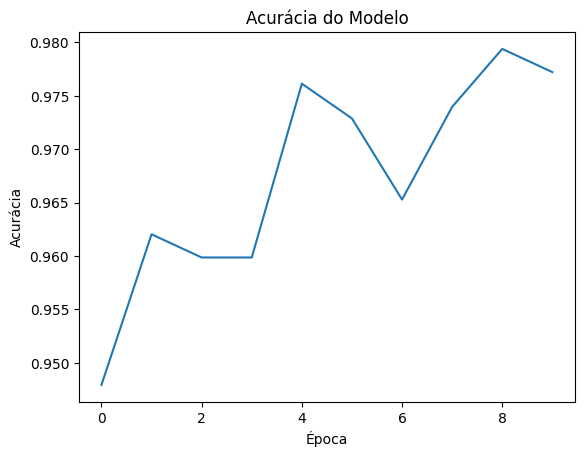

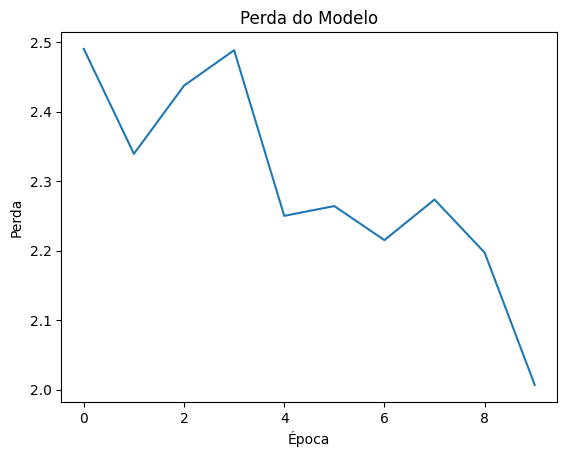

29/29 [==============================] - 4s 154ms/step


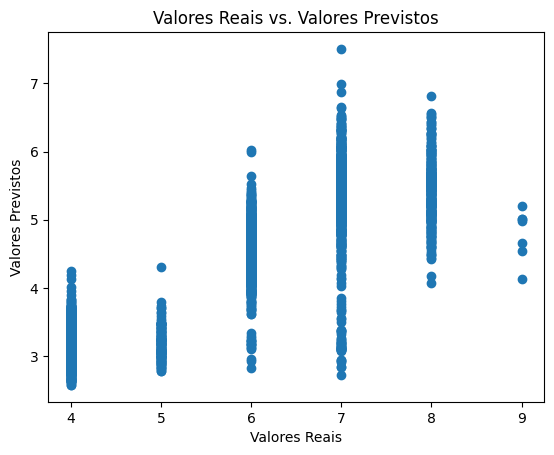

Erro Quadrático Médio (MSE): 2.2652543928639375
Coeficiente de Determinação (R²): -10.017082157796523


In [ ]:
# Treinar o modelo final com os melhores parâmetros e obter o histórico de treinamento
historico_final = modelo_final.fit(imagens, rotulos, epochs=10, batch_size=32, verbose=1)

# Plotar gráfico de acurácia
plt.plot(historico_final.history['accuracy'])
plt.title('Acurácia do Modelo')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.show()

# Plotar gráfico de perda
plt.plot(historico_final.history['loss'])
plt.title('Perda do Modelo')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.show()

# Obter valores previstos do modelo final
valores_previstos = modelo_final.predict(imagens)

# Extrair os valores reais
valores_reais = rotulos

# Plotar gráfico de dispersão dos valores reais vs. valores previstos
plt.scatter(valores_reais, valores_previstos)
plt.title('Valores Reais vs. Valores Previstos')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.show()


mse = mean_squared_error(valores_reais, valores_previstos)
print("Erro Quadrático Médio (MSE):", mse)

# Calcular o coeficiente de determinação (R²)
r2 = r2_score(valores_reais, valores_previstos)
print("Coeficiente de Determinação (R²):", r2)


#### Teste para predizer valores dos parametros para uma imagem qualquer

1/1 [==============================] - 0s 39ms/step
CCI: 0.6 Gamma: 0.5 Alfa: 0.4 Beta: 0.4


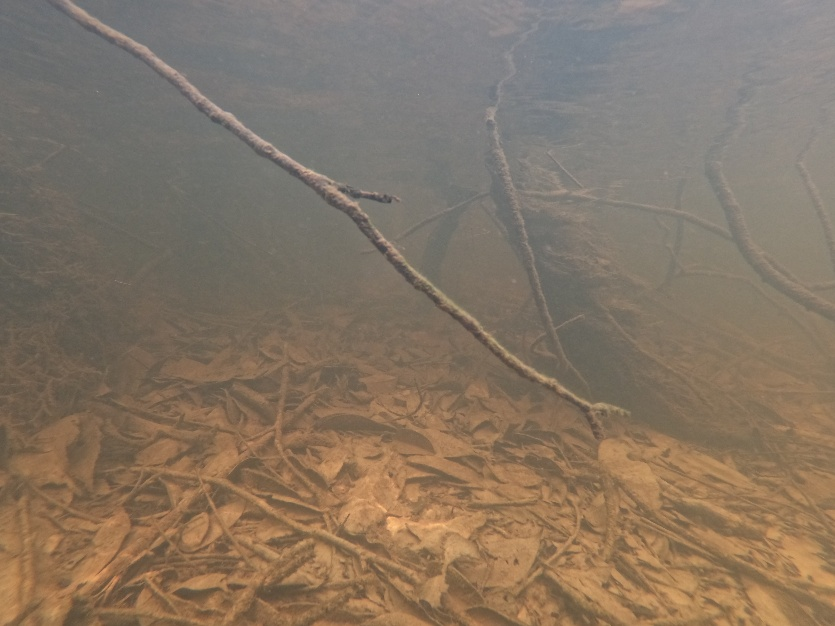

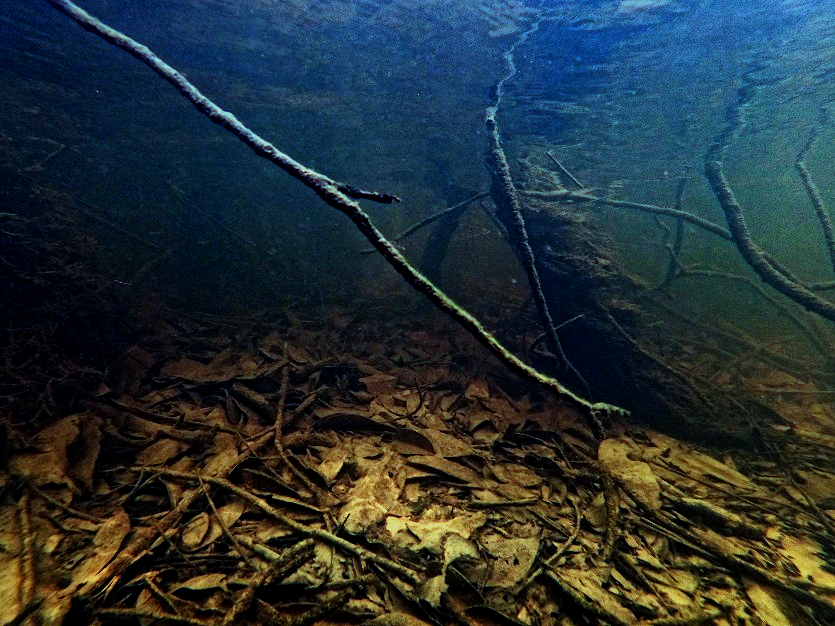

In [ ]:
# Faz previsões em novas imagens

DIR_IMG = '/content/drive/MyDrive/UWE/Data/Caru_Dataset/GOPR0441.JPG'
imagem_nova = Image.open(DIR_IMG)
imagem_nova = imagem_nova.resize((64, 64))  # Redimensiona a imagem para o mesmo tamanho das imagens de treinamento
imagem_nova_array = np.array(imagem_nova) / 255.0  # Normaliza os valores dos pixels
imagem_nova_array = np.expand_dims(imagem_nova_array, axis=0)  # Adiciona uma dimensão extra para a amostra única

predicao = modelo.predict(imagem_nova_array)
# print(f"CCI: {predicao[0][0]}, Gamma: {predicao[0][1]}, Alfa: {predicao[0][2]}, Beta: {predicao[0][3]}")

cci_pred = round(predicao[0][0] / 10.0, 1)
gamma_pred = round(predicao[0][1] / 10.0, 1)
alfa_pred = round(predicao[0][2] / 10.0, 1)
beta_pred = round(predicao[0][3] / 10.0, 1)

img = cv2.imread(DIR_IMG)
restored = UWE(img, cci_pred, gamma_pred, alfa_pred, beta_pred)

print("CCI:", cci_pred, "Gamma:", gamma_pred, "Alfa:", alfa_pred, "Beta:", beta_pred)

cv2_imshow(img)
cv2_imshow(restored)

#### Previsao de um exemplo do conjunto de teste

1/1 [==============================] - 0s 58ms/step
Valores Reais:
CCI: 0.7 Gamma: 0.6 Alfa: 0.4 Beta: 0.4


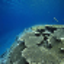

Valores Preditos:
CCI: 0.7 Gamma: 0.6 Alfa: 0.4 Beta: 0.4


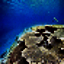

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
indice_teste = 5 # Índice do exemplo de teste a ser selecionado
imagem_teste = X_teste[indice_teste]
rotulo_real = y_teste[indice_teste]

# Faz a previsão do exemplo de teste
imagem_teste_array = np.expand_dims(imagem_teste, axis=0)
predicao_teste = modelo.predict(imagem_teste_array)[0]

imagem_teste_bgr = cv2.cvtColor((imagem_teste * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
# Exibe a imagem de teste

cci_real = round(rotulo_real[0] / 10.0, 1)
gamma_real = round(rotulo_real[1] / 10.0, 1)
alfa_real = round(rotulo_real[2] / 10.0, 1)
beta_real = round(rotulo_real[3] / 10.0, 1)

cci_predito = round(predicao_teste[0] / 10.0, 1)
gamma_predito = round(predicao_teste[1] / 10.0, 1)
alfa_predito = round(predicao_teste[2] / 10.0, 1)
beta_predito = round(predicao_teste[3] / 10.0, 1)

print("Valores Reais:")
print("CCI: {:.1f}".format(cci_real), "Gamma: {:.1f}".format(gamma_real), "Alfa: {:.1f}".format(alfa_real), "Beta: {:.1f}".format(beta_real))

cv2_imshow(imagem_teste_bgr)

print("Valores Preditos:")
print("CCI: {:.1f}".format(cci_predito), "Gamma: {:.1f}".format(gamma_predito), "Alfa: {:.1f}".format(alfa_predito), "Beta: {:.1f}".format(beta_predito))

restored = UWE(imagem_teste_bgr, cci_predito, gamma_predito, alfa_predito, beta_predito)
cv2_imshow(restored)

#### Avaliar todos os testes

In [ ]:
#FUNCAO AUXILIAR
def escreve(arquivo, vetor):
  with open(arquivo, 'w') as writefile:
    for h in range(len(vetor)):
      writefile.write(str(vetor[h]) + '\n')

In [ ]:
arquivo = '/content/drive/MyDrive/all_resultados.txt'
resultados = []
for indice_teste in range(len(X_teste)):
    # Obter a imagem de teste e o rótulo real
    imagem_teste = X_teste[indice_teste]
    rotulo_real = y_teste[indice_teste]

    # Fazer a previsão do exemplo de teste
    imagem_teste_array = np.expand_dims(imagem_teste, axis=0)
    predicao_teste = modelo.predict(imagem_teste_array)[0]
    imagem_teste_bgr = cv2.cvtColor((imagem_teste * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
    # Extrair os valores preditos de CCI, gamma, alfa e beta
    cci_predito = round(predicao_teste[0] / 10.0, 1)
    gamma_predito = round(predicao_teste[1] / 10.0, 1)
    alfa_predito = round(predicao_teste[2] / 10.0, 1)
    beta_predito = round(predicao_teste[3] / 10.0, 1)

    # Aplicar os valores preditos à imagem de teste e obter a imagem aprimorada
    restored = UWE(imagem_teste_bgr, cci_predito, gamma_predito, alfa_predito, beta_predito)

    # Calcular as métricas de qualidade
    uci = getUCIQE(restored)
    uiq = getUIQM(restored)

    # Armazenar os resultados
    string = f"{indice_teste}, {cci_predito:.1f}, {gamma_predito:.1f}, {alfa_predito:.1f}, {beta_predito:.1f}, {uci:.4f}, {uiq:.4f}"
    resultados.append(string)
escreve(arquivo, resultados)


1/1 [==============================] - 0s 29ms/step


In [ ]:
import pandas as pd

# Ler o arquivo de texto
with open('/content/drive/MyDrive/all_resultados.txt', 'r') as file:
    linhas = file.readlines()

# Criar uma lista vazia para armazenar os dados
dados = []

# Percorrer as linhas e dividir os valores pelo separador ','
for linha in linhas:
    valores = linha.strip().split(',')
    dados.append(valores)

# Criar um DataFrame usando os dados
df = pd.DataFrame(dados, columns=['Imagem', 'CCI', 'Gamma', 'Alfa', 'Beta', 'Uciqe', 'UIQM'])

# Salvar o DataFrame em um arquivo Excel
df.to_excel('tabela.xlsx', index=False)


In [ ]:
# Calcular a média dos valores da coluna 'Uciqe'
media_uciqe = df['Uciqe'].astype(float).mean()

# Calcular a média dos valores da coluna 'UIQM'
media_uiqm = df['UIQM'].astype(float).mean()

print(f"Média de Uciqe: {media_uciqe}")
print(f"Média de UIQM: {media_uiqm}")
